In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/당구장/Picture

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1-T9g26pyici3xu1RK324f98duFalKGHZ/당구장/Picture


In [3]:
from ast import literal_eval 

In [4]:
def read_all_file(path):
    output = os.listdir(path)
    file_list = []

    for i in output:
        if os.path.isdir(path+"/"+i): 
            file_list.extend(read_all_file(path+"/"+i)) 
        elif os.path.isfile(path+"/"+i):
            file_list.append(path+"/"+i)

    return file_list

filelists = read_all_file('TL_헬스_요가')
filelists.sort()
filelists

['TL_헬스_요가/yoga01/1037289_605.jpg',
 'TL_헬스_요가/yoga01/1066239_605.jpg',
 'TL_헬스_요가/yoga01/1073563_605.jpg',
 'TL_헬스_요가/yoga01/1073565_605.jpg',
 'TL_헬스_요가/yoga01/1081961_605.jpg',
 'TL_헬스_요가/yoga01/1163264_605.jpg',
 'TL_헬스_요가/yoga01/1168795_605.jpg',
 'TL_헬스_요가/yoga01/1178474_605.jpg',
 'TL_헬스_요가/yoga01/1190379_605.jpg',
 'TL_헬스_요가/yoga01/1191702_605.jpg',
 'TL_헬스_요가/yoga01/1201359_605.jpg',
 'TL_헬스_요가/yoga01/1201380_605.jpg',
 'TL_헬스_요가/yoga01/1203255_605.jpg',
 'TL_헬스_요가/yoga01/1239328_605.jpg',
 'TL_헬스_요가/yoga01/1239347_605.jpg',
 'TL_헬스_요가/yoga01/1244976_605.jpg',
 'TL_헬스_요가/yoga01/1244982_605.jpg',
 'TL_헬스_요가/yoga01/1245109_605.jpg',
 'TL_헬스_요가/yoga01/1245114_605.jpg',
 'TL_헬스_요가/yoga01/1245536_605.jpg',
 'TL_헬스_요가/yoga01/1245545_605.jpg',
 'TL_헬스_요가/yoga01/1246086_605.jpg',
 'TL_헬스_요가/yoga01/1251701_605.jpg',
 'TL_헬스_요가/yoga01/1279900_605.jpg',
 'TL_헬스_요가/yoga01/1279902_605.jpg',
 'TL_헬스_요가/yoga01/1279929_605.jpg',
 'TL_헬스_요가/yoga01/1279934_605.jpg',
 'TL_헬스_요가/yoga01/1279964_60

In [5]:
box_yoga = pd.read_csv('box_health_yoga.csv', index_col = 0)

In [6]:
box_yoga

,image,xmin,ymin,xmax,ymax,label
0,1037289_605.jpg,683,559,769,619,293
1,1066239_605.jpg,1501,717,1598,875,290
2,1066239_605.jpg,1602,723,1707,879,290
3,1073563_605.jpg,1324,979,1517,1088,290
4,1073565_605.jpg,1283,990,1460,1081,290
...,...,...,...,...,...,...
1553,945966_605.jpg,733,1160,884,1262,290
1554,960465_605.jpg,1484,1161,1598,1270,291
1555,988498_605.jpg,1200,1223,1368,1339,291
1556,988498_605.jpg,1456,1230,1610,1328,291


In [7]:
box_yoga.loc[(box_yoga['label'] == 285), 'label'] = 0
box_yoga.loc[(box_yoga['label'] == 286), 'label'] = 1
box_yoga.loc[(box_yoga['label'] == 287), 'label'] = 2
box_yoga.loc[(box_yoga['label'] == 288), 'label'] = 3
box_yoga.loc[(box_yoga['label'] == 289), 'label'] = 4
box_yoga.loc[(box_yoga['label'] == 290), 'label'] = 5
box_yoga.loc[(box_yoga['label'] == 291), 'label'] = 6
box_yoga.loc[(box_yoga['label'] == 292), 'label'] = 7
box_yoga.loc[(box_yoga['label'] == 293), 'label'] = 8
box_yoga.loc[(box_yoga['label'] == 294), 'label'] = 9
box_yoga.loc[(box_yoga['label'] == 295), 'label'] = 10
box_yoga.loc[(box_yoga['label'] == 296), 'label'] = 11
box_yoga.loc[(box_yoga['label'] == 297), 'label'] = 12
box_yoga.loc[(box_yoga['label'] == 298), 'label'] = 13

In [8]:
sorted(box_yoga['label'].unique()) #14개 class 존재

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [9]:
box_yoga

,image,xmin,ymin,xmax,ymax,label
0,1037289_605.jpg,683,559,769,619,8
1,1066239_605.jpg,1501,717,1598,875,5
2,1066239_605.jpg,1602,723,1707,879,5
3,1073563_605.jpg,1324,979,1517,1088,5
4,1073565_605.jpg,1283,990,1460,1081,5
...,...,...,...,...,...,...
1553,945966_605.jpg,733,1160,884,1262,5
1554,960465_605.jpg,1484,1161,1598,1270,6
1555,988498_605.jpg,1200,1223,1368,1339,6
1556,988498_605.jpg,1456,1230,1610,1328,6


In [10]:
class CarDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = df["image"].unique() # all image filenames
        self.data = df
        self.df = df[["image","xmin", "ymin", "xmax", "ymax"]]
        self.image_dir = image_dir # dir to image files
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image"] == image_id]
        label = self.data['label'][self.df["image"] == image_id]
        image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = torch.tensor(image)
        image = image.permute(2,0,1)
        
        
        boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        #여기를 어떻게 해야댈지 몰겟음
        labels = torch.tensor((label.values), dtype=torch.int64)

        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area


        if self.transforms:
            sample = {"image": image, "boxes": target["boxes"], "labels": labels}
            sample = self.transforms(**sample)
            image = sample["image"]
            target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [12]:
dir_train = "TL_헬스_요가/yoga01"

In [13]:
train_ds = CarDataset(box_yoga, dir_train)

In [14]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [17]:
model = fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
num_classes = 14 # 1 class (car) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

In [20]:
model.train()

num_epochs = 5

for epoch in range(num_epochs):
    
    for i, (images, targets, image_ids) in enumerate(train_dl):
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())

      losses.backward()
      optimizer.step()

      if (i+1) % 10 == 0:
        print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')

Epoch 1 - Total: 0.6223, Regression: 0.1069, Classifier: 0.4738
Epoch 1 - Total: 0.3381, Regression: 0.1373, Classifier: 0.1702
Epoch 1 - Total: 0.3223, Regression: 0.1418, Classifier: 0.1715
Epoch 1 - Total: 0.6802, Regression: 0.3148, Classifier: 0.3427
Epoch 1 - Total: 0.4323, Regression: 0.2216, Classifier: 0.1889
Epoch 1 - Total: 0.0836, Regression: 0.0181, Classifier: 0.0541
Epoch 1 - Total: 0.0247, Regression: 0.0000, Classifier: 0.0177
Epoch 1 - Total: 0.2898, Regression: 0.1560, Classifier: 0.1285
Epoch 1 - Total: 0.1049, Regression: 0.0420, Classifier: 0.0533
Epoch 1 - Total: 0.3919, Regression: 0.1399, Classifier: 0.2486
Epoch 1 - Total: 0.1256, Regression: 0.0446, Classifier: 0.0563
Epoch 1 - Total: 0.3625, Regression: 0.1687, Classifier: 0.1860
Epoch 1 - Total: 0.2874, Regression: 0.1500, Classifier: 0.1327
Epoch 1 - Total: 0.2274, Regression: 0.0824, Classifier: 0.1298
Epoch 1 - Total: 0.2276, Regression: 0.1226, Classifier: 0.0732
Epoch 1 - Total: 0.1764, Regression: 0.0

In [25]:
images = cv2.imread("TL_헬스_요가/yoga01/1948473_605.jpg", cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0
sample = images
images = torch.tensor(images)
images = images.permute(2,0,1)
images = torch.unsqueeze(images, 0)
images = images.to(device)
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
mask = outputs[0]['scores'] > 0.3
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)

In [28]:
torch.save(model.state_dict(),f'object_detection_model.pt')
#model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

In [26]:
outputs

[{'boxes': tensor([[ 640.8083,  677.2166,  790.6030,  760.1761],
          [ 631.1481,  665.7589,  808.3307,  770.5113],
          [   0.0000,  415.4338,   87.7296,  620.2933],
          [ 643.5903,  681.9309,  794.0349,  757.3548],
          [ 641.2786,  680.5079,  800.3887,  765.1744],
          [ 657.0446,  678.6658,  787.9792,  759.4927],
          [   0.0000,  421.9359,   92.6010,  614.1837],
          [ 644.7214,  681.5803,  796.2311,  756.5166],
          [   0.0000,  422.5714,   92.2547,  635.0731],
          [ 651.9767,  674.3831,  785.9238,  765.0073],
          [ 645.9710,  671.6497,  800.3996,  763.4442],
          [   0.0000,  409.4704,   90.1112,  631.7281],
          [   0.0000,  422.7470,   90.6956,  627.7411],
          [2454.8613,  359.1939, 2598.3987,  465.5880],
          [   0.0000,  424.0920,   87.7504,  626.9109],
          [   0.0000,  430.2623,   94.4692,  614.4344],
          [2462.2146,  360.2710, 2600.2393,  470.8594],
          [2420.6902,  362.6616, 2608.0

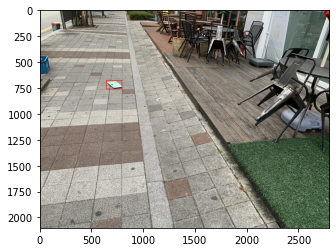

In [27]:
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
plt.imshow(sample)